<a href="https://colab.research.google.com/github/GitGreg228/sepmp_ml_2023/blob/main/seminars/seminar_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm
from google.colab.patches import cv2_imshow
from scipy import integrate
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from copy import deepcopy
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset


ROWS = 64
COLS = 64
CHANNELS = 3

In [2]:
digits = load_digits()

In [20]:
X = digits.data
y = digits.target

In [21]:
X.shape

(1797, 64)

In [22]:
X[0].reshape(8, 8)

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

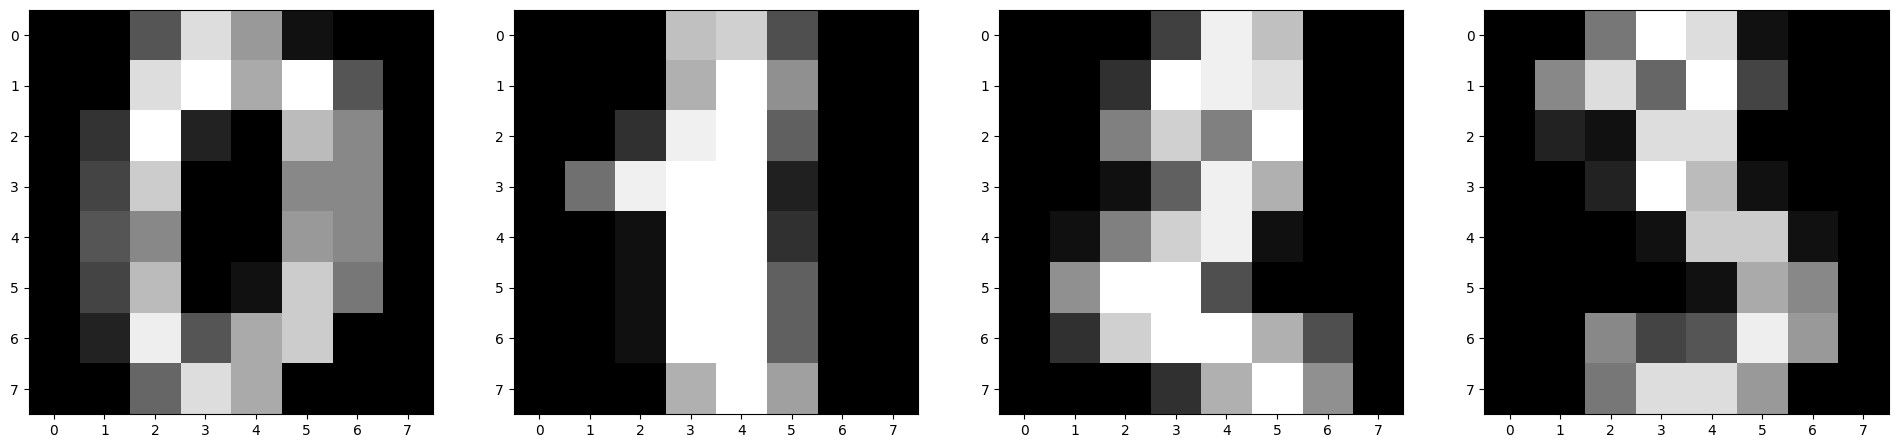

In [23]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
ax1.imshow(digits.images[0], cmap='gray')
ax2.imshow(digits.images[1], cmap='gray')
ax3.imshow(digits.images[2], cmap='gray')
ax4.imshow(digits.images[3], cmap='gray')

In [24]:
def normalize(X_in, a=0, b=1):
    # normalising from [X_min, X_max] to [a, b]
    # task : implement a function that gets X_in as vector/matrix and returns X_out in a desired range
    # hint : all functions you need are min - np.min(X_in), max - np.max(X_in)
    return (b - a) * (X_in - np.min(X_in)) / (np.max(X_in) - np.min(X_in)) + a

In [27]:
X = digits.data
y = digits.target

mask1 = y == 1
mask2 = y == 7
mask = mask1 + mask2

X = X[mask]
y = y[mask]
y[y == 7] = 0

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(normalize(X[mask]), y[mask], test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, X_test.shape)

(288, 64) (36, 64) (37, 64)


In [28]:
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)
X_val, y_val = torch.Tensor(X_val), torch.Tensor(y_val)
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

In [30]:
bs = 30  # batch_size

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=bs)
val_loader = DataLoader(val_data, batch_size=bs)
test_loader = DataLoader(test_data, batch_size=bs)

In [31]:
class Logistic_Regression(torch.nn.Module):
    def __init__(self, in_size=64, out_size=1):
        super().__init__()
        self.layers = torch.nn.Sequential(
                torch.nn.Linear(in_size, out_size),
                torch.nn.Sigmoid(),
            )
    
    def forward(self, x):
        return self.layers(x)

In [32]:
model = Logistic_Regression()
list(model.parameters())

[Parameter containing:
 tensor([[-0.0418,  0.0856,  0.0330, -0.0736, -0.0320,  0.1184, -0.1007, -0.0180,
           0.0884,  0.0758, -0.0886, -0.0654, -0.0170, -0.0254, -0.0279, -0.0039,
           0.0107, -0.0642, -0.0838,  0.0600,  0.0524,  0.0043,  0.1194, -0.0628,
           0.0935,  0.0823, -0.0375,  0.0400, -0.0649, -0.0017, -0.0652,  0.0566,
          -0.0975, -0.0582,  0.0373, -0.0136,  0.0841, -0.0366, -0.1196,  0.0640,
           0.0372, -0.0629,  0.0785, -0.0867,  0.0783, -0.0918,  0.0345, -0.1003,
           0.0549, -0.1007, -0.0835, -0.0123,  0.0248, -0.0992,  0.0049, -0.0140,
          -0.0056, -0.0599, -0.0897, -0.0746,  0.0034, -0.0474,  0.0653,  0.0175]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0538], requires_grad=True)]

In [33]:
def train(model, criterion, optimizer, n_epochs, n_stop=10):
    train_loss = list()
    val_loss = list()
    min_val_loss = np.inf
    f = 0
    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_batch_loss = list()
        for batch in train_loader:
            optimizer.zero_grad()
            _X, _y = batch
            _y_pred = model(_X)
            loss = criterion(_y_pred, _y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_batch_loss.append(loss.item())

        model.eval()
        val_batch_loss = list()
        for batch in val_loader:
            _X, _y = batch
            _y_pred = model(_X)
            loss = criterion(_y_pred, _y.unsqueeze(1))
            val_batch_loss.append(loss.item())

        # print(f'Epoch: {epoch}, \tTrain loss: {np.mean(train_batch_loss)}, \tValidation loss: {np.mean(val_batch_loss)}')
        train_loss.append(np.mean(train_batch_loss))
        val_loss.append(np.mean(val_batch_loss))

        # (optional) early stopping:

        if val_loss[-1] > min_val_loss:
            f = f + 1
        else:
            # print(f'epoch: {epoch}, val loss did decrease, saving model')
            f = 0
            best_model = deepcopy(model)
            min_val_loss = val_loss[-1]
        if f >= n_stop:
            print(f'epoch: {epoch}, val loss did not decrease for {f} epoch(s)')
            break

    return best_model, train_loss, val_loss

In [34]:
model = Logistic_Regression()

criterion = torch.nn.BCELoss()

alpha = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=alpha, weight_decay=0.03)

model, train_loss, val_loss = train(model, criterion, optimizer, n_epochs=10000, n_stop=100)

  7%|▋         | 728/10000 [00:10<02:09, 71.74it/s]

epoch: 728, val loss did not decrease for 100 epoch(s)


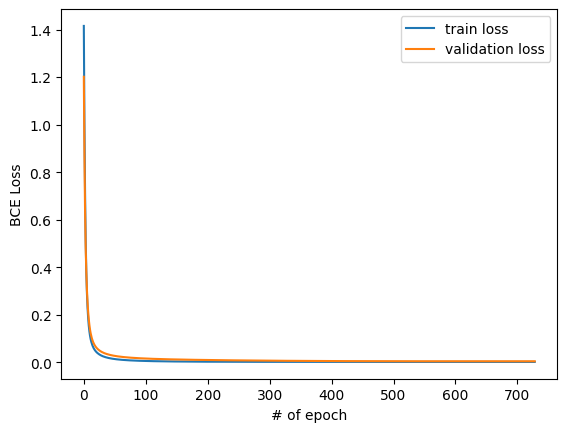

In [35]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.legend()
plt.ylabel('BCE Loss')
plt.xlabel('# of epoch')
plt.show()

In [40]:
with torch.no_grad():
    for batch in test_loader:
        _X, _y = batch
        _y_pred = model(_X)
        loss = criterion(_y_pred, _y.unsqueeze(1))
        print(f'y: {_y}, \ny_pred = {_y_pred.squeeze()}, \nloss = {loss.item()}')

y: tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.]), 
y_pred = tensor([9.9983e-01, 2.4891e-05, 4.6305e-04, 3.2343e-05, 9.9943e-01, 9.9974e-01,
        9.9280e-01, 4.1060e-04, 9.9998e-01, 9.2652e-05, 9.8963e-01, 1.3487e-04,
        2.9088e-04, 4.3803e-05, 1.7212e-04, 9.8979e-01, 1.3840e-02, 2.9051e-04,
        3.3294e-04, 9.9828e-01, 4.4752e-04, 2.4299e-03, 9.9996e-01, 9.9998e-01,
        9.9706e-01, 9.9999e-01, 9.9999e-01, 9.9431e-01, 1.9430e-06, 2.0752e-06]), 
loss = 0.001949578756466508
y: tensor([1., 0., 1., 1., 0., 1., 0.]), 
y_pred = tensor([9.9993e-01, 2.6077e-02, 9.9970e-01, 9.9997e-01, 6.7664e-05, 9.9999e-01,
        3.5221e-04]), 
loss = 0.0038936254568398


In [41]:
model(torch.Tensor(X[1]))

tensor([0.0001], grad_fn=<SigmoidBackward0>)

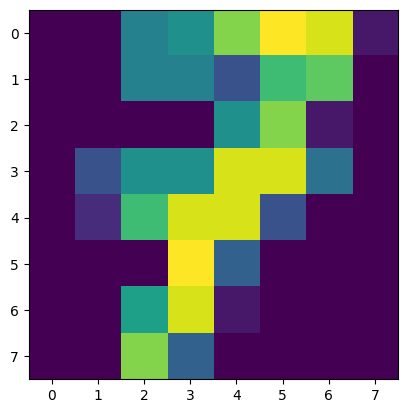

In [42]:
plt.imshow(X[1].reshape(8, 8))

# Cats and dogs dataset

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jM6FPtWf3rmsfyFTOrPNOgHMkzhAIT8b' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jM6FPtWf3rmsfyFTOrPNOgHMkzhAIT8b" -O cats_and_dogs.zip && rm -rf /tmp/cookies.txt

In [ ]:
!unzip -q cats_and_dogs.zip

In [ ]:
cats_train_dir = os.path.join('training_set', 'training_set', 'cats')
dogs_train_dir = os.path.join('training_set', 'training_set', 'dogs')

cats_train_fnames = list([os.path.join(cats_train_dir, fname) for fname in os.listdir(cats_train_dir)])
dogs_train_fnames = list([os.path.join(dogs_train_dir, fname) for fname in os.listdir(dogs_train_dir)])

train_fnames = np.random.permutation(cats_train_fnames + dogs_train_fnames)

In [ ]:
cats_test_dir = os.path.join('test_set', 'test_set', 'cats')
dogs_test_dir = os.path.join('test_set', 'test_set', 'dogs')

cats_test_fnames = list([os.path.join(cats_test_dir, fname) for fname in os.listdir(cats_test_dir)])
dogs_test_fnames = list([os.path.join(dogs_test_dir, fname) for fname in os.listdir(dogs_test_dir)])

test_fnames = np.random.permutation(cats_test_fnames + dogs_test_fnames)

In [ ]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    try:
        result = cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
    except:
        result = None
    return result

In [ ]:
def prep_data(images):
    """
    Returns:
        X(n_x, m)
        y(1, m) -- 1: dog, 0: cat
    """
    m = len(images)
    n_x = ROWS * COLS * CHANNELS
    
    X = list()
    y = list()
    # print ("X shape is {}".format(X.shape))
    
    for i in tqdm(range(len(images))):
        image_file = images[i]
        image = read_image(image_file)
        if image is not None:
            X.append(np.squeeze(image.reshape((n_x, 1))))
            if 'dog' in image_file.lower():
                y.append(1)
            elif 'cat' in image_file.lower():
                y.append(-1)
            else:# if neither dog nor cat exist, return the image index (this is the case for test data)
                y.append(0)
        # if i%1000 == 0: print('Processed {} of {}'.format(i, m))
    
    X = np.array(X)
    y = np.array(y)
    print ("X shape is {}".format(X.shape))

    return X, y

In [ ]:
cv2_imshow(read_image(test_fnames[40]))

In [ ]:
X_train, y_train = prep_data(train_fnames)

In [ ]:
X_test, y_test = prep_data(test_fnames)

In [ ]:
def margin(y_in, X_in, w):
    # task : implement margin function described above
    # hint 1 : np.dot - for scalar product and matrix multiplication
    # hint 2 : * - Adamar product
    return y_in * np.dot(X_in, w)

In [ ]:
def sigmoid(M):
    # task : implement sigmoid function described above
    return 1 / (1 + np.exp(-M))

In [ ]:
def loss(M):
    # task : implement logistic regression loss function
    # hint 1 : log(a) = np.log(a)
    # hint 2 : sum(arr) = np.sum(arr)
    return np.mean(np.log(1 + np.exp(-M)))

In [ ]:
def p(X_in, w):
    # task : implement probability function described above
    # hint 1 : np.dot - for scalar product and matrix multiplication
    # hint 2 : e^a = np.exp(a)
    return 1 / (1 + np.exp( - np.dot(X_in, w)))

In [ ]:
def predict(X_in, w, a=0.5):
    # task : implement the prediction function
    # hint : p+ is implemented above
    c = p(X_in, w)
    c[c >= a] = 1
    c[c < a] = -1
    return c

In [ ]:
def Loss_grad(w):
    # task : calculate the gradient of loss function defined above
    M = margin(y_train, X_train, w)
    # grad = np.zeros(w.shape)
    y_ = np.tile(y_train, (w.shape[0], 1)).T
    M_ = np.tile(M, (w.shape[0], 1)).T
    return np.mean((1-sigmoid(M_)) * y_ * X_train, axis=0)

In [ ]:
def TP(y_pred, y_true):
    return np.sum(y_pred[y_pred == 1] == y_true[y_pred == 1])

def TN(y_pred, y_true):
    return np.sum(y_pred[y_pred == -1] == y_true[y_pred == -1])

def FP(y_pred, y_true):
    return np.sum(y_pred[y_pred == 1] != y_true[y_pred == 1])

def FN(y_pred, y_true):
    return np.sum(y_pred[y_pred == -1] != y_true[y_pred == -1])

def TPR(y_pred, y_true):
    if TP(y_pred, y_true) + FN(y_pred, y_true) > 0:
        return TP(y_pred, y_true) / (TP(y_pred, y_true) + FN(y_pred, y_true))
    else:
        return 0

def FPR(y_pred, y_true):
    if FP(y_pred, y_true) + TN(y_pred, y_true) > 0:
        return FP(y_pred, y_true) / (FP(y_pred, y_true) + TN(y_pred, y_true))
    else:
        return 0

In [ ]:
def roc_curve(X_in, w_in, y_in, n_points=100):
    x_fpr = list()
    y_tpr = list()
    A = np.linspace(0, 1, n_points)
    for a in A[::-1]:
        y_pred = predict(X_in, w_in, a=a)
        x_fpr.append(FPR(y_pred, y_in))
        y_tpr.append(TPR(y_pred, y_in))
    return np.array(x_fpr), np.array(y_tpr)

NameError: ignored